In [1]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

import sys
sys.path.append('../')
from src import datasets, metrics

In [6]:
#  
trainfile = Path('../data/heart_big_train.parq').resolve()
testfile = Path('../data/heart_big_test.parq').resolve()
trainfile, testfile

(PosixPath('/home/azureuser/code/mads-exam-24-FalcovdHoogen/data/heart_train.parq'),
 PosixPath('/home/azureuser/code/mads-exam-24-FalcovdHoogen/data/heart_test.parq'))

Get the 1D data into a 2D matrix

In [9]:
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape, use_fraction=0.5)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape, use_fraction=0.5)
traindataset, testdataset
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = "cpu"

traindataset.to(device)
testdataset.to(device)


Let's see how that works. 
Compare this to the 1D data to see if you understand the transformation.

(torch.Size([1, 16, 12]), tensor(0))

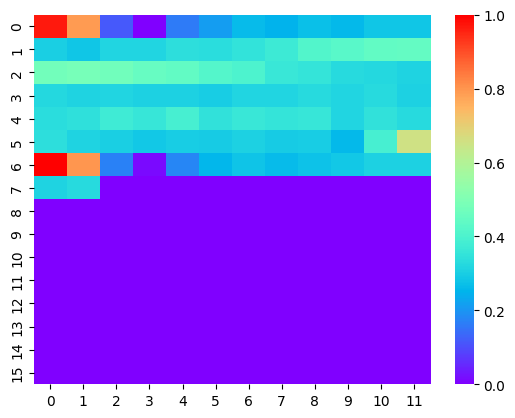

In [4]:
x, y = traindataset[0]
# Assuming your tensor is named 'tensor'
viz = x.squeeze().cpu().numpy()
sns.heatmap(viz, cmap='rainbow')
x.shape, y

Load into a streamer

In [10]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(363, 90)

In [83]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 1, 16, 12]), torch.Size([32]))

The ConvBlock makes it easier to stack block in the model.
Feel free to experiment with other architectures here:
- adding ideas like resnet, googlenet, squeeze-excite, etc.
- add additional layers like dropout, batchnorm, etc.
- experiment with different ways to go from 4D to 2D tensors

In [39]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
    def forward(self, x):
        return self.conv(x)
    

In [84]:
# Conv with resnet
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # Define a 1x1 convolution to match the dimensions if necessary
        self.match_dimensions = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1) if in_channels != out_channels else nn.Identity()
        
        # BatchNorm layer after the addition of skip connection
        self.final_norm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        identity = x.clone() # Save the input for the skip connection
        x = self.conv(x) # Pass through the convolutional block
        identity = self.match_dimensions(identity) # Match dimensions if necessary
        x += identity # Add the original input (skip connection)
        x = self.final_norm(x) # Normalize the output
        return x

In [8]:
import torch
class CNN(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()
        hidden = config['hidden']
        self.convolutions = nn.ModuleList([
            ConvBlock(1, hidden),
        ])

        for i in range(config['num_layers']):
            self.convolutions.extend([ConvBlock(hidden, hidden), nn.ReLU()])
        self.convolutions.append(nn.MaxPool2d(2, 2))

        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear((8*6) * hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, config['num_classes']),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for conv in self.convolutions:
            x = conv(x)
        x = self.dense(x)
        return x

In [85]:
# Changed model (added: dropout and batchnorm2D/1D)

import torch
class CNN(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()
        hidden = config['hidden']
        dropout_rate = config('dropout_rate')
        self.convolutions = nn.ModuleList([
            ConvBlock(1, hidden, dropout_rate),
        ])

        for i in range(config['num_layers']):
            self.convolutions.extend([ConvBlock(hidden, hidden, dropout_rate), nn.ReLU()])
        self.convolutions.append(nn.MaxPool2d(2, 2))

        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear((8*6) * hidden, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden, config['num_classes']),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for conv in self.convolutions:
            x = conv(x)
        x = self.dense(x)
        return x

In [92]:
from src import models
config = {
    'hidden' : 32,
    'num_layers' : 3,
    'num_classes' : 5, # 5 for big dataset
    'dropout_rate': 0.1,
    'shape' : shape,

}
model = models.CNN(config)
model.to(device)
model(x).shape

2024-06-25 14:49:15.019 | INFO     | src.models:__init__:37 - Activation map size: 48
2024-06-25 14:49:15.020 | INFO     | src.models:__init__:38 - Input linear: 1536


torch.Size([32, 5])

In [88]:
yhat = model(x)

The data is unbalanced, so we are interested in much more than just accuracy.

In [89]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [90]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("2D conv model")

<Experiment: artifact_location='/home/azureuser/code/mads-exam-24/notebooks/mlruns/1', creation_time=1718731886699, experiment_id='1', last_update_time=1718731886699, lifecycle_stage='active', name='2D conv model', tags={}>

In [93]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=10,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="mlruns/heart2D",
        train_steps=len(trainstreamer),
        valid_steps=len(teststreamer),
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    settings.optimizer_kwargs = {'lr': 0.001}

    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D_ResNet")
    mlflow.set_tag("dataset", "heart_big_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()


2024-06-25 14:49:19.136 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to mlruns/heart2D/20240625-144919
100%|██████████| 2736/2736 [01:47<00:00, 25.51it/s]
2024-06-25 14:51:21.446 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.2805 test 0.1590 metric ['0.9527', '0.9527', '0.7852', '0.9527', '0.7862']
100%|██████████| 2736/2736 [01:48<00:00, 25.20it/s]
2024-06-25 14:53:24.820 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.1251 test 0.1234 metric ['0.9672', '0.9672', '0.8570', '0.9672', '0.8566']
100%|██████████| 2736/2736 [01:47<00:00, 25.38it/s]
2024-06-25 14:55:28.064 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.0973 test 0.0968 metric ['0.9739', '0.9739', '0.8755', '0.9739', '0.9000']
100%|██████████| 2736/2736 [01:49<00:00, 25.01it/s]
2024-06-25 14:57:33.055 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.0827 test 0.0889 metric ['0.9778', '0.9778', '0.8869', '0.9778', '0.9010']
100%|██████████| 2736/2736 [01:47<00

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

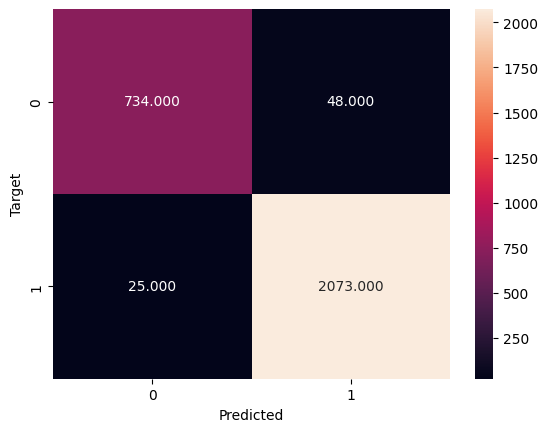

In [ ]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
# cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")